In [4]:
# ─── SETUP ─────────────────────────────────────────────────────────────
!pip install transformers torch scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.9 MB/s eta 0:00:00


In [5]:
# ─── IMPORTS ────────────────────────────────────────────────────────────
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm


In [6]:
# ─── GOOGLE DRIVE SETUP ─────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# ─── CONFIG ─────────────────────────────────────────────────────────────
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 5
MODEL_PATH = "/content/drive/MyDrive/ddi_classifier2.pth"

In [8]:
# ─── LOAD YOUR DATA ─────────────────────────────────────────────────────
df = pd.read_csv("/content/drive/MyDrive/drugbank_ddi_dataset.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle data
NUM_CLASSES = df['Y'].nunique()

In [9]:
# ─── LOAD CHEMBERTA ─────────────────────────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chemberta = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1").to(DEVICE)

def smiles_to_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = chemberta(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze(0).cpu()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [10]:
# ─── EMBEDDING + LABEL EXTRACTION ───────────────────────────────────────
X_data, y_data = [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        emb1 = smiles_to_embedding(row['Drug1'])
        emb2 = smiles_to_embedding(row['Drug2'])
        X_data.append(torch.cat((emb1, emb2)))
        y_data.append(int(row['Y']) - 1)  # Shift to 0-based classes
    except:
        continue

X_tensor = torch.stack(X_data)
y_tensor = torch.tensor(y_data)

# ─── SPLIT DATA ─────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# ─── MODEL ──────────────────────────────────────────────────────────────
class DDIClassifier(nn.Module):
    def __init__(self, input_dim=1536, num_classes=NUM_CLASSES):
        super(DDIClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

  0%|          | 55/191808 [00:01<45:32, 70.18it/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

100%|██████████| 191808/191808 [37:55<00:00, 84.29it/s]


In [11]:
EPOCHS = 10000

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt

model = DDIClassifier().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Metric storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []

best_loss = float('inf')
patience = 20
trigger_times = 0

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    output = model(X_train.to(DEVICE))
    train_loss = criterion(output, y_train.to(DEVICE))
    train_loss.backward()
    optimizer.step()

    # Training metrics
    with torch.no_grad():
        train_preds = torch.argmax(output, dim=1).cpu()
        train_acc = accuracy_score(y_train.cpu(), train_preds)
        train_precision = precision_score(y_train.cpu(), train_preds, average='macro', zero_division=0)
        train_recall = recall_score(y_train.cpu(), train_preds, average='macro', zero_division=0)
        train_f1 = f1_score(y_train.cpu(), train_preds, average='macro', zero_division=0)

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_test.to(DEVICE))
        val_loss = criterion(val_output, y_test.to(DEVICE))
        val_preds = torch.argmax(val_output, dim=1).cpu()
        val_acc = accuracy_score(y_test.cpu(), val_preds)
        val_precision = precision_score(y_test.cpu(), val_preds, average='macro', zero_division=0)
        val_recall = recall_score(y_test.cpu(), val_preds, average='macro', zero_division=0)
        val_f1 = f1_score(y_test.cpu(), val_preds, average='macro', zero_division=0)

    # Logging
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_precisions.append(train_precision)
    val_precisions.append(val_precision)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(
        f"Epoch {epoch+1}/{EPOCHS} - "
        f"Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss.item():.4f} - "
        f"Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f} - "
        f"Train Prec: {train_precision:.4f} - Val Prec: {val_precision:.4f} - "
        f"Train Rec: {train_recall:.4f} - Val Rec: {val_recall:.4f} - "
        f"Train F1: {train_f1:.4f} - Val F1: {val_f1:.4f}"
    )

    # Early stopping
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        trigger_times = 0
        torch.save(model.state_dict(), MODEL_PATH)
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"⛔ Early stopping at epoch {epoch+1} (no val loss improvement in {patience} epochs)")
            break


Streaming output truncated to the last 5000 lines.
Epoch 2096/10000 - Train Loss: 0.6267 - Val Loss: 0.5723 - Train Acc: 0.8038 - Val Acc: 0.8270 - Train Prec: 0.7571 - Val Prec: 0.7206 - Train Rec: 0.5470 - Val Rec: 0.5407 - Train F1: 0.6016 - Val F1: 0.5843
Epoch 2097/10000 - Train Loss: 0.6259 - Val Loss: 0.5722 - Train Acc: 0.8023 - Val Acc: 0.8267 - Train Prec: 0.7680 - Val Prec: 0.7203 - Train Rec: 0.5461 - Val Rec: 0.5404 - Train F1: 0.5994 - Val F1: 0.5840
Epoch 2098/10000 - Train Loss: 0.6278 - Val Loss: 0.5719 - Train Acc: 0.8033 - Val Acc: 0.8270 - Train Prec: 0.7497 - Val Prec: 0.7204 - Train Rec: 0.5527 - Val Rec: 0.5427 - Train F1: 0.6082 - Val F1: 0.5860
Epoch 2099/10000 - Train Loss: 0.6261 - Val Loss: 0.5717 - Train Acc: 0.8027 - Val Acc: 0.8269 - Train Prec: 0.7688 - Val Prec: 0.7205 - Train Rec: 0.5508 - Val Rec: 0.5426 - Train F1: 0.6058 - Val F1: 0.5859
Epoch 2100/10000 - Train Loss: 0.6237 - Val Loss: 0.5715 - Train Acc: 0.8045 - Val Acc: 0.8267 - Train Prec: 0.76


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.98      0.85      0.91        71
           2       1.00      1.00      1.00       105
           3       0.83      0.88      0.85      1012
           4       0.97      0.86      0.91        66
           5       0.93      0.96      0.95       635
           6       1.00      0.67      0.80         3
           7       0.73      0.80      0.76        44
           8       0.98      0.96      0.97       427
           9       0.91      0.98      0.94       117
          10       0.80      0.62      0.70        52
          11       1.00      0.76      0.86        50
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00        75
          14       0.74      0.88      0.81        26
          15       0.94      0.97      0.96      1082
          16       1.00      0.82      0.90        11
   

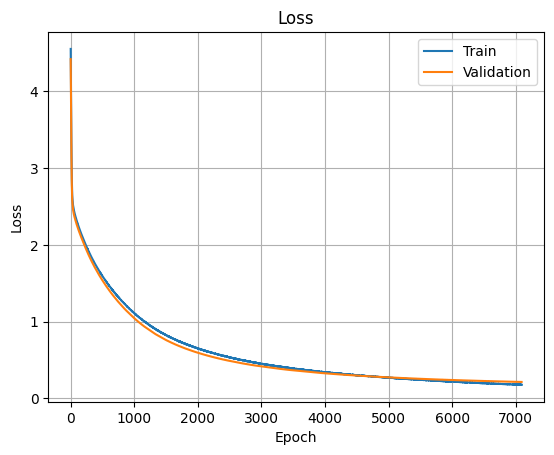

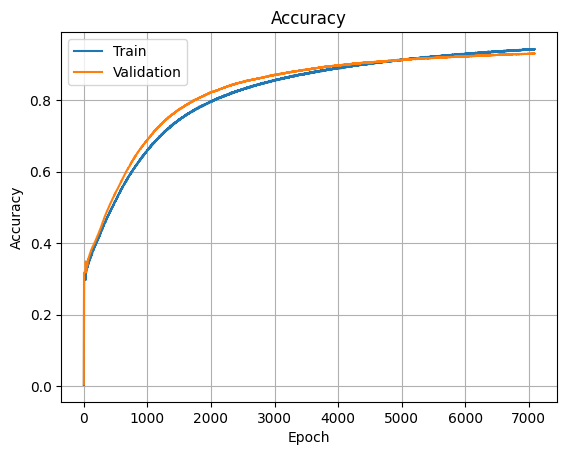

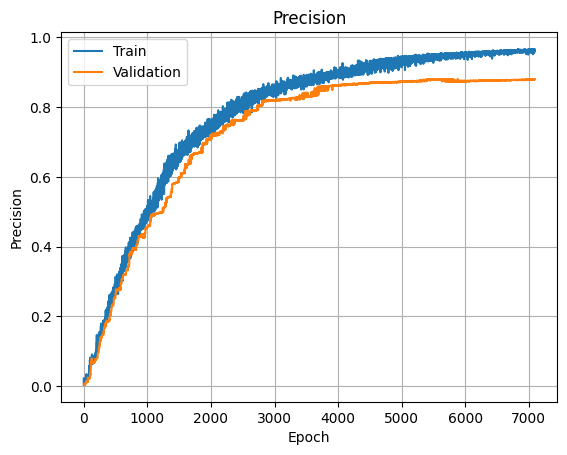

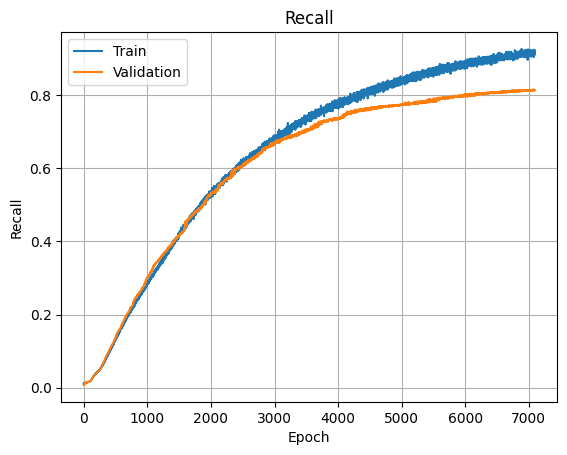

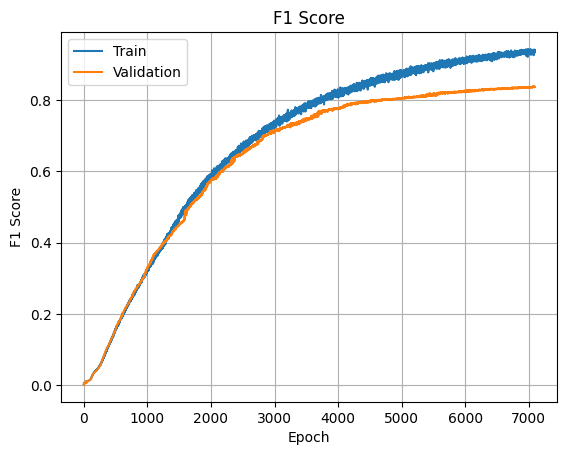

In [13]:
# ─── EVALUATE ───────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    logits = model(X_test.to(DEVICE))
    preds = torch.argmax(logits, dim=1).cpu()

print("\nClassification Report:")
print(classification_report(y_test, preds, zero_division=0))
print("Accuracy:", accuracy_score(y_test, preds))

# ─── PLOT ───────────────────────────────────────────────────────────────
def plot_metric(train_values, val_values, title, ylabel):
    plt.figure()
    plt.plot(train_values, label="Train")
    plt.plot(val_values, label="Validation")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(train_losses, val_losses, "Loss", "Loss")
plot_metric(train_accuracies, val_accuracies, "Accuracy", "Accuracy")
plot_metric(train_precisions, val_precisions, "Precision", "Precision")
plot_metric(train_recalls, val_recalls, "Recall", "Recall")
plot_metric(train_f1s, val_f1s, "F1 Score", "F1 Score")

In [14]:
# ─── INFERENCE FUNCTION ─────────────────────────────────────────────────
def predict_ddi_class(smiles1, smiles2):
    emb1 = smiles_to_embedding(smiles1)
    emb2 = smiles_to_embedding(smiles2)
    input_vec = torch.cat((emb1, emb2)).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(input_vec)
        pred = torch.argmax(logits, dim=1).item()
    return pred + 1  # shift back to original Y labels (1 to 86)

In [15]:
# ─── EXAMPLE INFERENCE ──────────────────────────────────────────────────
s1 = df.iloc[0]['Drug1']
s2 = df.iloc[0]['Drug2']
print("\nPredicted class:", predict_ddi_class(s1, s2))


Predicted class: 47


In [26]:
# ─── INFERENCE-ONLY MODULE ─────────────────────────────────────────────
!pip install transformers torch --quiet


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Top DDI Class Predictions:
Class 49 → Confidence: 0.9813
Class 64 → Confidence: 0.0136
Class 73 → Confidence: 0.0036


In [31]:
!pip install PyTDC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.2/154.2 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [18]:
# ─── INFERENCE-ONLY MODULE ─────────────────────────────────────────────
!pip install transformers torch PyTDC --quiet

import torch
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

# ─── CONFIG ─────────────────────────────────────────────────────────────
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "/content/drive/MyDrive/ddi_classifier.pth"
NUM_CLASSES = 86  # Keep same as training

# ─── MOUNT GOOGLE DRIVE ─────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

# ─── LOAD CHEMBERTA ─────────────────────────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chemberta = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1").to(DEVICE)

def smiles_to_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = chemberta(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze(0).cpu()

# ─── MODEL DEFINITION ───────────────────────────────────────────────────
class DDIClassifier(nn.Module):
    def __init__(self, input_dim=1536, num_classes=NUM_CLASSES):
        super(DDIClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# ─── LOAD SAVED MODEL ───────────────────────────────────────────────────
model = DDIClassifier().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ─── DDI LABEL MAP (MANUAL FALLBACK) ──────────────────────────────────
label_map = {1: 'Drug a can cause a decrease in the absorption of Drug b resulting in a reduced serum concentration and potentially a decrease in efficacy.', 2: 'Drug a can cause an increase in the absorption of Drug b resulting in an increased serum concentration and potentially a worsening of adverse effects.', 3: 'The absorption of Drug b can be decreased when combined with Drug a.', 4: 'The bioavailability of Drug b can be decreased when combined with Drug a.', 5: 'The bioavailability of Drug b can be increased when combined with Drug a.', 6: 'The metabolism of Drug b can be decreased when combined with Drug a.', 7: 'The metabolism of Drug b can be increased when combined with Drug a.', 8: 'The protein binding of Drug b can be decreased when combined with Drug a.', 9: 'The serum concentration of Drug b can be decreased when it is combined with Drug a.', 10: 'The serum concentration of Drug b can be increased when it is combined with Drug a.', 11: 'The serum concentration of the active metabolites of Drug b can be increased when Drug b is used in combination with Drug a.', 12: 'The serum concentration of the active metabolites of Drug b can be reduced when Drug b is used in combination with Drug a resulting in a loss in efficacy.', 13: 'The therapeutic efficacy of Drug b can be decreased when used in combination with Drug a.', 14: 'The therapeutic efficacy of Drug b can be increased when used in combination with Drug a.', 15: 'Drug a may decrease the excretion rate of Drug b which could result in a higher serum level.', 16: 'Drug a may increase the excretion rate of Drug b which could result in a lower serum level and potentially a reduction in efficacy.', 17: 'Drug a may decrease the cardiotoxic activities of Drug b.', 18: 'Drug a may increase the cardiotoxic activities of Drug b.', 19: 'Drug a may increase the central neurotoxic activities of Drug b.', 20: 'Drug a may increase the hepatotoxic activities of Drug b.', 21: 'Drug a may increase the nephrotoxic activities of Drug b.', 22: 'Drug a may increase the neurotoxic activities of Drug b.', 23: 'Drug a may increase the ototoxic activities of Drug b.', 24: 'Drug a may decrease effectiveness of Drug b as a diagnostic agent.', 25: 'The risk of a hypersensitivity reaction to Drug b is increased when it is combined with Drug a.', 26: 'The risk or severity of adverse effects can be increased when Drug a is combined with Drug b.', 27: 'The risk or severity of bleeding can be increased when Drug a is combined with Drug b.', 28: 'The risk or severity of heart failure can be increased when Drug b is combined with Drug a.', 29: 'The risk or severity of hyperkalemia can be increased when Drug a is combined with Drug b.', 30: 'The risk or severity of hypertension can be increased when Drug b is combined with Drug a.', 31: 'The risk or severity of hypotension can be increased when Drug a is combined with Drug b.', 32: 'The risk or severity of QTc prolongation can be increased when Drug a is combined with Drug b.', 33: 'Drug a may decrease the analgesic activities of Drug b.', 34: 'Drug a may decrease the anticoagulant activities of Drug b.', 35: 'Drug a may decrease the antihypertensive activities of Drug b.', 36: 'Drug a may decrease the antiplatelet activities of Drug b.', 37: 'Drug a may decrease the bronchodilatory activities of Drug b.', 38: 'Drug a may decrease the diuretic activities of Drug b.', 39: 'Drug a may decrease the neuromuscular blocking activities of Drug b.', 40: 'Drug a may decrease the sedative activities of Drug b.', 41: 'Drug a may decrease the stimulatory activities of Drug b.', 42: 'Drug a may decrease the vasoconstricting activities of Drug b.', 43: 'Drug a may increase the adverse neuromuscular activities of Drug b.', 44: 'Drug a may increase the analgesic activities of Drug b.', 45: 'Drug a may increase the anticholinergic activities of Drug b.', 46: 'Drug a may increase the anticoagulant activities of Drug b.', 47: 'Drug a may increase the antihypertensive activities of Drug b.', 48: 'Drug a may increase the antiplatelet activities of Drug b.', 49: 'Drug a may increase the antipsychotic activities of Drug b.', 50: 'Drug a may increase the arrhythmogenic activities of Drug b.', 51: 'Drug a may increase the atrioventricular blocking (AV block) activities of Drug b.', 52: 'Drug a may increase the bradycardic activities of Drug b.', 53: 'Drug a may increase the bronchoconstrictory activities of Drug b.', 54: 'Drug a may increase the central nervous system depressant (CNS depressant) activities of Drug b.', 55: 'Drug a may increase the central nervous system depressant (CNS depressant) and hypertensive activities of Drug b.', 56: 'Drug a may increase the constipating activities of Drug b.', 57: 'Drug a may increase the dermatologic adverse activities of Drug b.', 58: 'Drug a may increase the fluid retaining activities of Drug b.', 59: 'Drug a may increase the hypercalcemic activities of Drug b.', 60: 'Drug a may increase the hyperglycemic activities of Drug b.', 61: 'Drug a may increase the hyperkalemic activities of Drug b.', 62: 'Drug a may increase the hypertensive activities of Drug b.', 63: 'Drug a may increase the hypocalcemic activities of Drug b.', 64: 'Drug a may increase the hypoglycemic activities of Drug b.', 65: 'Drug a may increase the hypokalemic activities of Drug b.', 66: 'Drug a may increase the hyponatremic activities of Drug b.', 67: 'Drug a may increase the hypotensive activities of Drug b.', 68: 'Drug a may increase the hypotensive and central nervous system depressant (CNS depressant) activities of Drug b.', 69: 'Drug a may increase the immunosuppressive activities of Drug b.', 70: 'Drug a may increase the myelosuppressive activities of Drug b.', 71: 'Drug a may increase the myopathic rhabdomyolysis activities of Drug b.', 72: 'Drug a may increase the neuroexcitatory activities of Drug b.', 73: 'Drug a may increase the neuromuscular blocking activities of Drug b.', 74: 'Drug a may increase the orthostatic hypotensive activities of Drug b.', 75: 'Drug a may increase the photosensitizing activities of Drug b.', 76: 'Drug a may increase the QTc-prolonging activities of Drug b.', 77: 'Drug a may increase the respiratory depressant activities of Drug b.', 78: 'Drug a may increase the sedative activities of Drug b.', 79: 'Drug a may increase the serotonergic activities of Drug b.', 80: 'Drug a may increase the stimulatory activities of Drug b.', 81: 'Drug a may increase the tachycardic activities of Drug b.', 82: 'Drug a may increase the thrombogenic activities of Drug b.', 83: 'Drug a may increase the ulcerogenic activities of Drug b.', 84: 'Drug a may increase the vasoconstricting activities of Drug b.', 85: 'Drug a may increase the vasodilatory activities of Drug b.', 86: 'Drug a may increase the vasopressor activities of Drug b.'}


# ─── INFERENCE FUNCTION ─────────────────────────────────────────────────
def predict_ddi(smiles1, smiles2, top_k=3):
    emb1 = smiles_to_embedding(smiles1)
    emb2 = smiles_to_embedding(smiles2)
    input_vec = torch.cat((emb1, emb2)).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(input_vec)
        probs = F.softmax(logits, dim=1).squeeze()
        top_probs, top_classes = torch.topk(probs, k=top_k)

    results = [(cls.item() + 1, prob.item()) for cls, prob in zip(top_classes, top_probs)]
    return results

# ─── EXAMPLE ────────────────────────────────────────────────────────────
# Provide two SMILES strings below:
smiles1 = "C\C(\C=C\C1=C(C)CCCC1(C)C)=C/C=C/C(/C)=C\C(O)=O"  #
smiles2 = "[H][C@@]12[C@@H](C)C3=CC=CC(O)=C3C(=O)C1=C(O)[C@]1(O)C(=O)C(C(N)=O)=C(O)[C@@H](N(C)C)[C@]1([H])[C@H]2O"       #

results = predict_ddi(smiles1, smiles2)

print("\nTop DDI Class Predictions:")
for cls, prob in results:
    label = label_map.get(cls, f"Class {cls}")
    print(f"{label} (Class {cls}) → Confidence: {prob:.4f}")

# Warn if top prediction has low confidence
if results[0][1] < 0.5:
    print("⚠️ Warning: Model is not confident in its top prediction. Please review manually.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Top DDI Class Predictions:
Drug a may increase the antihypertensive activities of Drug b. (Class 47) → Confidence: 0.9947
Drug a may increase the neuromuscular blocking activities of Drug b. (Class 73) → Confidence: 0.0043
Drug a may increase the antipsychotic activities of Drug b. (Class 49) → Confidence: 0.0004


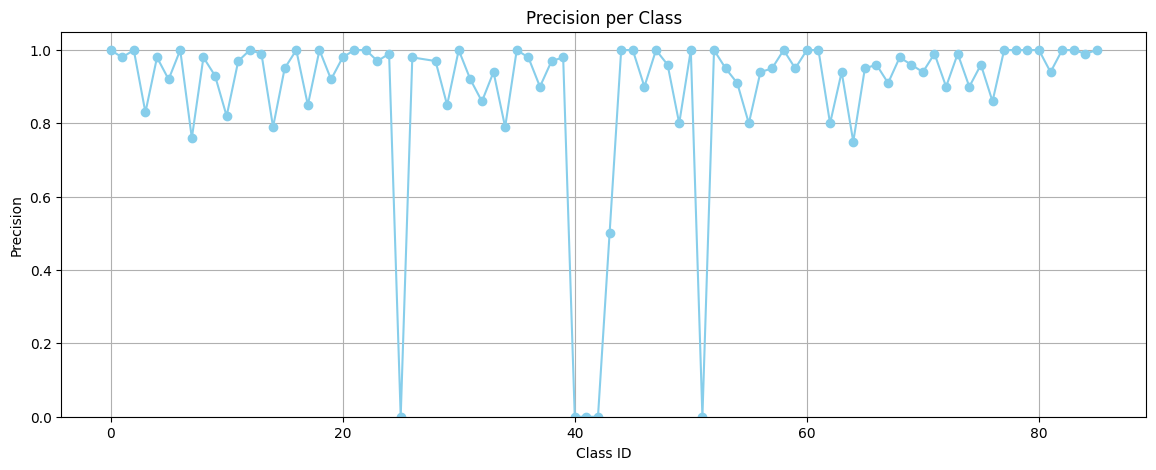

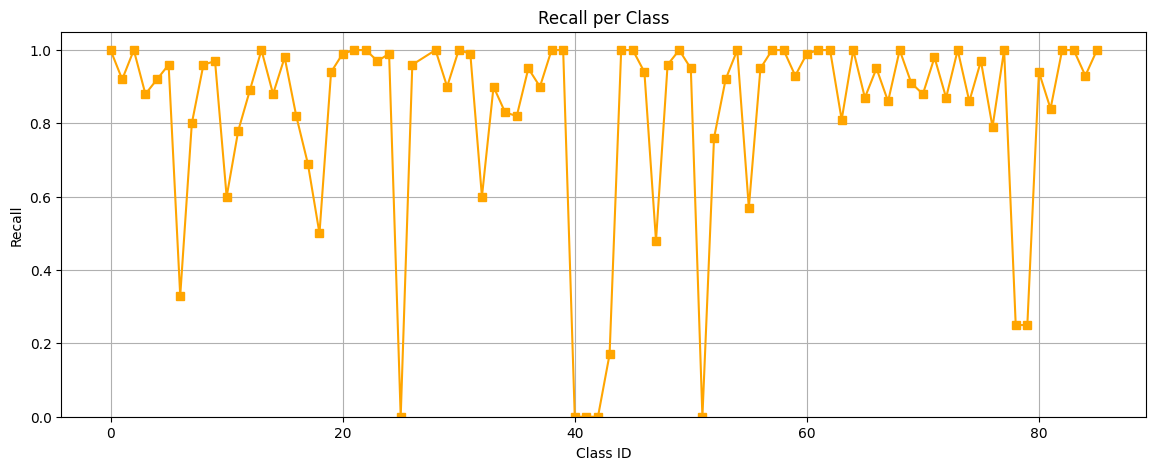

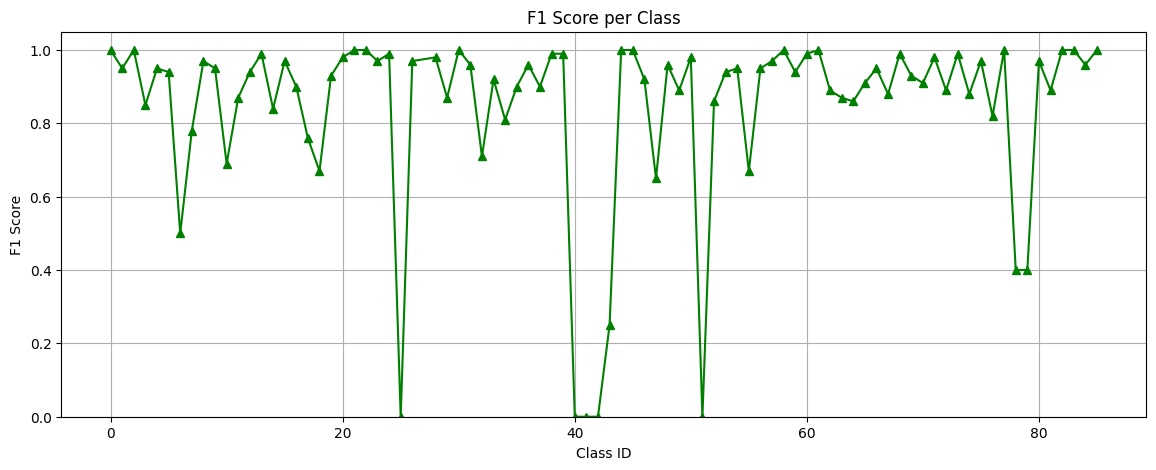

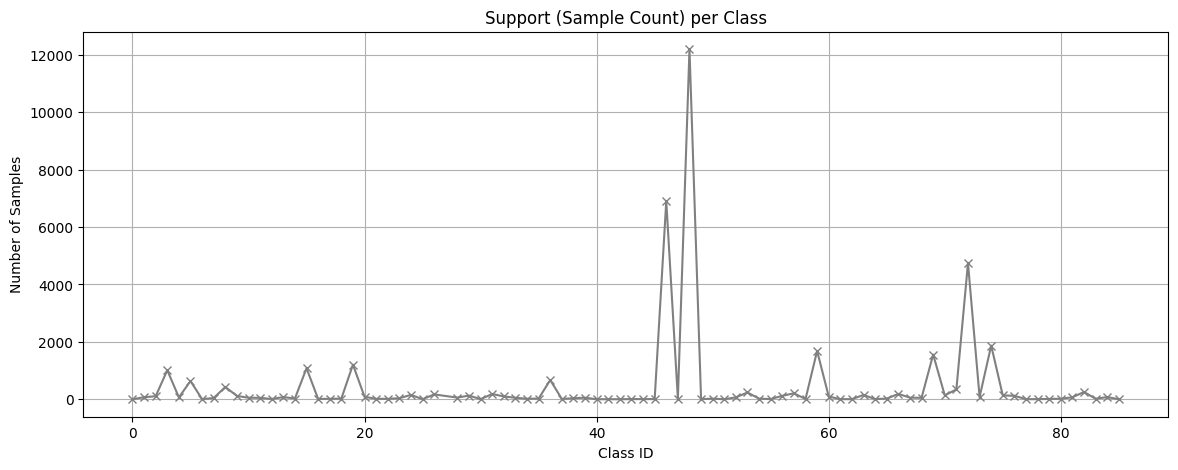